In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/")
import importlib
import structures
importlib.reload(structures)
from structures import *
#import losses
#importlib.reload(losses)
#from losses import *
#import trainer
#importlib.reload(trainer)
#from trainer import *
#dtype = torch.float32
#dtype = torch.double
dtype = torch.float32
torch.set_default_dtype(dtype)
torch.autograd.set_detect_anomaly(True)
# Set the device to CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#import deepspeed
import random
sys.path.append("/mnt/home/yjo10/ceph/myutils")
import plt_utils as pu

torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()
# Cosine‑annealing with warmup
#from timm.scheduler import create_scheduler
from types import SimpleNamespace
from tqdm import tqdm


Using device: cuda


In [19]:
import validator 
importlib.reload(validator)
from validator import *
output_dim = 1

model1 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model1.to(device)
model2 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model2.to(device)
model1.load_state_dict(torch.load("../data/models/SIMBA_T_LH_om_no_linear_best.pt"))
model2.load_state_dict(torch.load("../data/models/SIMBA_T_LH_sig_no_linear_best.pt"))

<All keys matched successfully>

In [4]:
output_dim = 1
model1 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model1.to(device)
model2 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model2.to(device)
model1.load_state_dict(torch.load("../data/models/IllustrisTNG_T_LH_om_no_linear_best.pt"))
model2.load_state_dict(torch.load("../data/models/IllustrisTNG_T_LH_sig_no_linear_best.pt"))
model1.eval()
model2.eval()
traced_model = torch.jit.script(model1)
traced_model.save("model_tng_om.pt")
traced_model = torch.jit.script(model2)
traced_model.save("model_tng_sig.pt")

RuntimeError: 
Module 'ConventionalCNN' has no attribute 'conv7' :
  File "/mnt/home/yjo10/projects/Comparison25_50/notebooks/../src/structures.py", line 306
        x = self.conv(x)
        if self.input_dim == 512:
            x = self.conv7(x)
                ~~~~~~~~~~ <--- HERE
        x = self.fcl(x)
        if self.output_positive:


In [5]:
from torch import jit
example = torch.randn(1, 1, 256, 256, device=device)
# After loading state_dict and calling .to(device):

# Trace model1
traced1 = jit.trace(model1, example)  
jit.save(traced1, "model_tng_om.pt")    # Overwrites? Use unique filenames

# Trace model2
traced2 = jit.trace(model2, example)  
jit.save(traced2, "model_tng_sig.pt")

##  25 Mpc cutout box of SB35

### data load

In [2]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()

29

In [3]:
batch_size=64
_dataSIMBA, _labelsSIMBA, _minmaxSIMBA          = loadCAMELS(sim="SIMBA",field="T",box="LH", normalization=False)
_dataSIMBA_CV, _labelsSIMBA_CV, _minmaxSIMBA_CV = loadCAMELS(sim="SIMBA",field="T",box="CV", normalization=False)
_dataSIMBA_P0, _labelsSIMBA_P0, _minmaxSIMBA_P0 = loadCAMELS(sim="SIMBA",field="T",box="1P", normalization=False)
_dataTNG_CV, _labelsTNG_CV, _minmaxTNG_CV       = loadCAMELS(sim="IllustrisTNG",field="T",box="CV", normalization=False)
_dataTNG_P0, _labelsTNG_P0, _minmaxTNG_P0       = loadCAMELS(sim="IllustrisTNG",field="T",box="1P", normalization=False)
#_dataAREPO_SIMBA = np.load("/mnt/ceph/users/fgarcia/data_products/simba_test_latest/Images_T_simba_test_bh_fgas_1_032_z=0.05.npy")
_dataAREPO_SIMBA = np.load("/mnt/ceph/users/fgarcia/data_products/simba_test_latest_z0/Images_T_arepo_simba_latest_033_z=0.00.npy")
#_dataAREPO_SIMBA = np.load("/mnt/ceph/users/fgarcia/data_products/simba_test_latest_temp_maps_z0/gas_temperature_033.npy")
_labelsAREPO_SIMBA = _labelsSIMBA_CV[0,:].reshape(1,-1)

_dataList   = [_dataSIMBA_CV, _dataSIMBA_P0[30:45,:,:], _dataTNG_CV, _dataTNG_P0[30:45,:,:], _dataAREPO_SIMBA]
#_labelsList = [_labelsSIMBA_CV, _labelsSIMBA_P0[2,:], _labelsTNG_CV, _labelsSIMBA_P0[2,:], _labelsAREPO_SIMBA]

In [4]:
dataSIMBA_norm = np.log10(_dataSIMBA)
dataSIMBA_norm_mean, dataSIMBA_norm_std = dataSIMBA_norm.mean(), dataSIMBA_norm.std()
dataSIMBA_norm = (dataSIMBA_norm -  dataSIMBA_norm_mean)/dataSIMBA_norm_std

dataList_norm = list()

for i in range(len(_dataList)):
  data_tmp = (np.log10(_dataList[i]) - dataSIMBA_norm_mean)/dataSIMBA_norm_std
  dataList_norm.append(data_tmp)

labelsSIMBA = _labelsSIMBA[:,:2]
labelsSIMBA = (labelsSIMBA-_minmaxSIMBA[:2,0])/(_minmaxSIMBA[:2,1]-_minmaxSIMBA[:2,0])

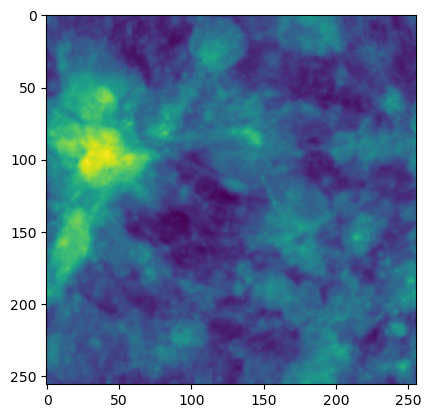

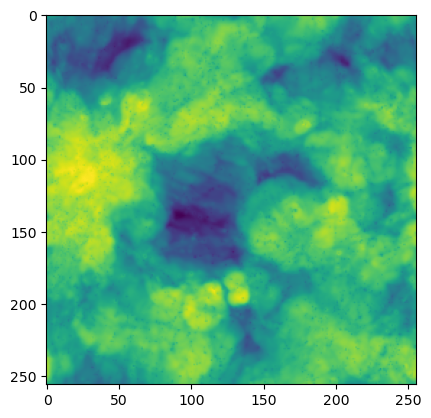

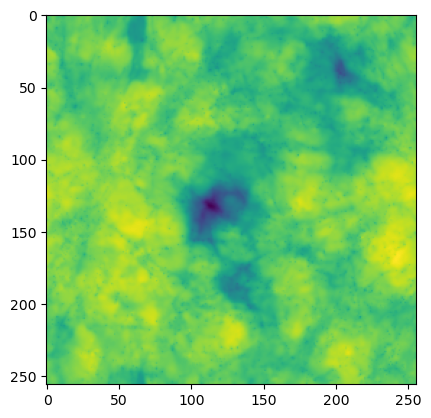

In [13]:
plt.imshow(np.log10(_dataTNG_P0[30:35,:,:]).mean(axis=0))
plt.show()
plt.imshow(np.log10(_dataAREPO_SIMBA[0:5,:,:]).mean(axis=0))
plt.show()
plt.imshow(np.log10(_dataSIMBA_P0[30:35,:,:]).mean(axis=0))
plt.show()

In [5]:
dataSIMBA = torch.tensor(dataSIMBA_norm,dtype=dtype)
labelsSIMBA = torch.tensor(labelsSIMBA,dtype=dtype)
train_setSIMBA, val_setSIMBA = split_expanded_dataset(dataSIMBA, labelsSIMBA, chunk_size=15, val_ratio=0.2)
val_loaderSIMBA = DataLoader(val_setSIMBA, batch_size=batch_size, shuffle=False)

## Methods

In [6]:
def get_predictions0(model, model1, val_loader, minmax, max_plots=6, device='cuda'):
    model.eval()
    model1.eval()
    predictions = []
    predictions1 = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            outputs1 = model1(inputs)
            predictions.append(outputs.cpu())
            predictions1.append(outputs1.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    predictions1 = torch.cat(predictions1, dim=0).numpy()  # [N, D]
    predictions = np.c_[predictions,predictions1]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]
    predictions = predictions*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]
    truths      = truths*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]

    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]

def get_predictions1(model, model1, _datalist, minmax, max_plots=6, device='cuda'):
    model.eval()
    model1.eval()
    predictions = []
    predictions1 = []
    pred = []

    with torch.no_grad():
        for inputs in _datalist:
            predictions = []
            predictions1 = []
            inputs = torch.tensor(inputs)
            if inputs.shape[0] > batch_size:
                for i in range((inputs.shape[0]+batch_size-1)//batch_size):
                    start = batch_size*i
                    end   = min(batch_size*(i+1),inputs.shape[0])
                    _inputs = inputs[start:end]
                    _inputs = _inputs.view(_inputs.size(0),1,256,256)
                    _inputs = _inputs.to(device)
                    outputs = model(_inputs)
                    outputs1 = model1(_inputs)
                    predictions.append(outputs.cpu())
                    predictions1.append(outputs1.cpu())
            else:
                _inputs = inputs.view(inputs.size(0),1,256,256)
                _inputs = _inputs.to(device)

                outputs = model(_inputs)
                outputs1 = model1(_inputs)
                predictions.append(outputs.cpu())
                predictions1.append(outputs1.cpu())

            predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
            predictions1 = torch.cat(predictions1, dim=0).numpy()  # [N, D]
            predictions = np.c_[predictions,predictions1]
            predictions = predictions*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]
            pred.append(predictions)

    # Plot prediction vs truth for a few dimensions
    return pred


def plot_AREPO_SIMBA(data1, pred, figsize, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None):
    fontsize = 30
    plt.rcParams['font.size'] = '15'
    plt.rcParams['font.family'] = 'sans-serif'
    #plt.rcParams['font.sans-serif'] = 'sans-serif'
    plt.rcParams['xtick.labelsize'] = '10'
    plt.rcParams['ytick.labelsize'] = '10'
    truths, predictions, plot_dims = data1
    fid = [0.3,0.8]

    fig, axs = plt.subplots(plot_dims,1, figsize=figsize)
    axs = np.array(axs).reshape(-1)

    c = ['cornflowerblue','darkblue', 'gold','firebrick' ,"red"]
    labels = ['SIMBA CV','SIMBA P0', 'TNG CV', "TNG P0", "AREPO SIMBA"]
    title = [r'$\Omega_m$', r"$\sigma_8$"]
    for i in range(plot_dims):
        axs[i].scatter(truths[:, i], predictions[:, i], color="darkgrey",
                    alpha=0.6, edgecolors='none', marker='.',s=16)
        for j,_pred in enumerate(pred):
            axs[i].scatter([fid[i]]*_pred.shape[0], _pred[:, i],
                        color=c[j], #label=labels[j],
                        alpha=1.0, edgecolors='white', lw=0.5,marker='.',s=64,zorder=10)
        for j,_pred in enumerate(pred):
            axs[i].scatter([fid[i]], np.mean(_pred[:, i]),
                        color=c[j], label=labels[j],
                        alpha=1.0, edgecolors='white', marker='*',s=200,zorder=11)
        # overplot your dots with individual colors
        axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    color='grey', ls="--", label='Ideal',alpha=0.8)
        #axs[i].axvline(fid[i], color='r', ls='--', label='Fiducial')
        axs[i].set_title(title[i])
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("Prediction")
        axs[i].legend()
        axs[i].grid(True)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()

    return 
    

def fiducial_histogram(pred,figsize=(10,15)):
    fid = [0.3,0.8]

    fig, axs = plt.subplots(5,1, figsize=figsize,
                            gridspec_kw={'wspace': 0,  # horizontal space between plots (fraction of subplot width)
                            'height_ratios':[0.1,0.2,0.05,0.1,0.2],
                                        'hspace':0})
    axs = np.array(axs).reshape(-1)
    axs[2].axis("off")

    c = ['cornflowerblue','darkblue', 'gold','firebrick' ,"red"]
    labels = ['SIMBA CV','SIMBA P0', 'TNG CV', "TNG P0", "AREPO SIMBA"]
    title = [r'$\Omega_m$', r"$\sigma_8$"]
    for i in range(2):
        for j,_pred in enumerate(pred):
            #axs[i].scatter([fid[i]]*_pred.shape[0], _pred[:, i],
            axs[i*3].scatter(_pred[:, i], [fid[i]]*_pred.shape[0], 
                        color=c[j], #label=labels[j],
                        alpha=1.0, edgecolors='white', lw=0.5,marker='.',s=64,zorder=10)
            axs[1+i*3].hist(_pred[:, i],color=c[j],density=True, histtype='step',lw=3, label=labels[j])
            # compute density histogram (like hist with density=True)
            #counts, bin_edges = np.histogram(_pred[:, i],
            #                                bins='auto',
            #                                density=True)

            # compute bin‐centers
            #bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

            # plot as line
            #axs[1 + i*3].plot(bin_centers, counts, color=c[j], lw=2)
            #axs[1 + i*3].set_ylabel("Density")
        for j,_pred in enumerate(pred):
            #axs[i].scatter([fid[i]], np.mean(_pred[:, i]),
            axs[i*3].scatter(np.mean(_pred[:, i]), [fid[i]], 
                        color=c[j], label=labels[j],
                        alpha=1.0, edgecolors='white', marker='*',s=200,zorder=11)
            axs[1+i*3].axvline(np.mean(_pred[:, i]), color=c[j], ls='--',lw=2)
            print(np.std(_pred[:, i]))
        # overplot your dots with individual colors
        #axs[i].axvline(fid[i], color='r', ls='--', label='Fiducial')
        axs[i*3].set_title(title[i])
        #axs[i].set_xlabel("Truth")
        axs[1+i*3].set_xlabel("Prediction")
        axs[i*3+1].legend()
        axs[i*3].grid(True)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()
    
    

## On SIMBA

In [7]:
import validator 
importlib.reload(validator)
from validator import *
output_dim = 1

model1 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model1.to(device)
model2 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model2.to(device)
model1.load_state_dict(torch.load("../data/models/SIMBA_T_LH_om_no_linear_best.pt"))
model2.load_state_dict(torch.load("../data/models/SIMBA_T_LH_sig_no_linear_best.pt"))

data0 = get_predictions0(model1, model2, val_loaderSIMBA, _minmaxSIMBA, device=device, max_plots=6)
pred  = get_predictions1(model1, model2, dataList_norm, _minmaxSIMBA, device=device, max_plots=6)
#plt.savefig("train_on_SB28_test_on_both.png")

Validation MSE (average over 2 targets): 2.343859e-03


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


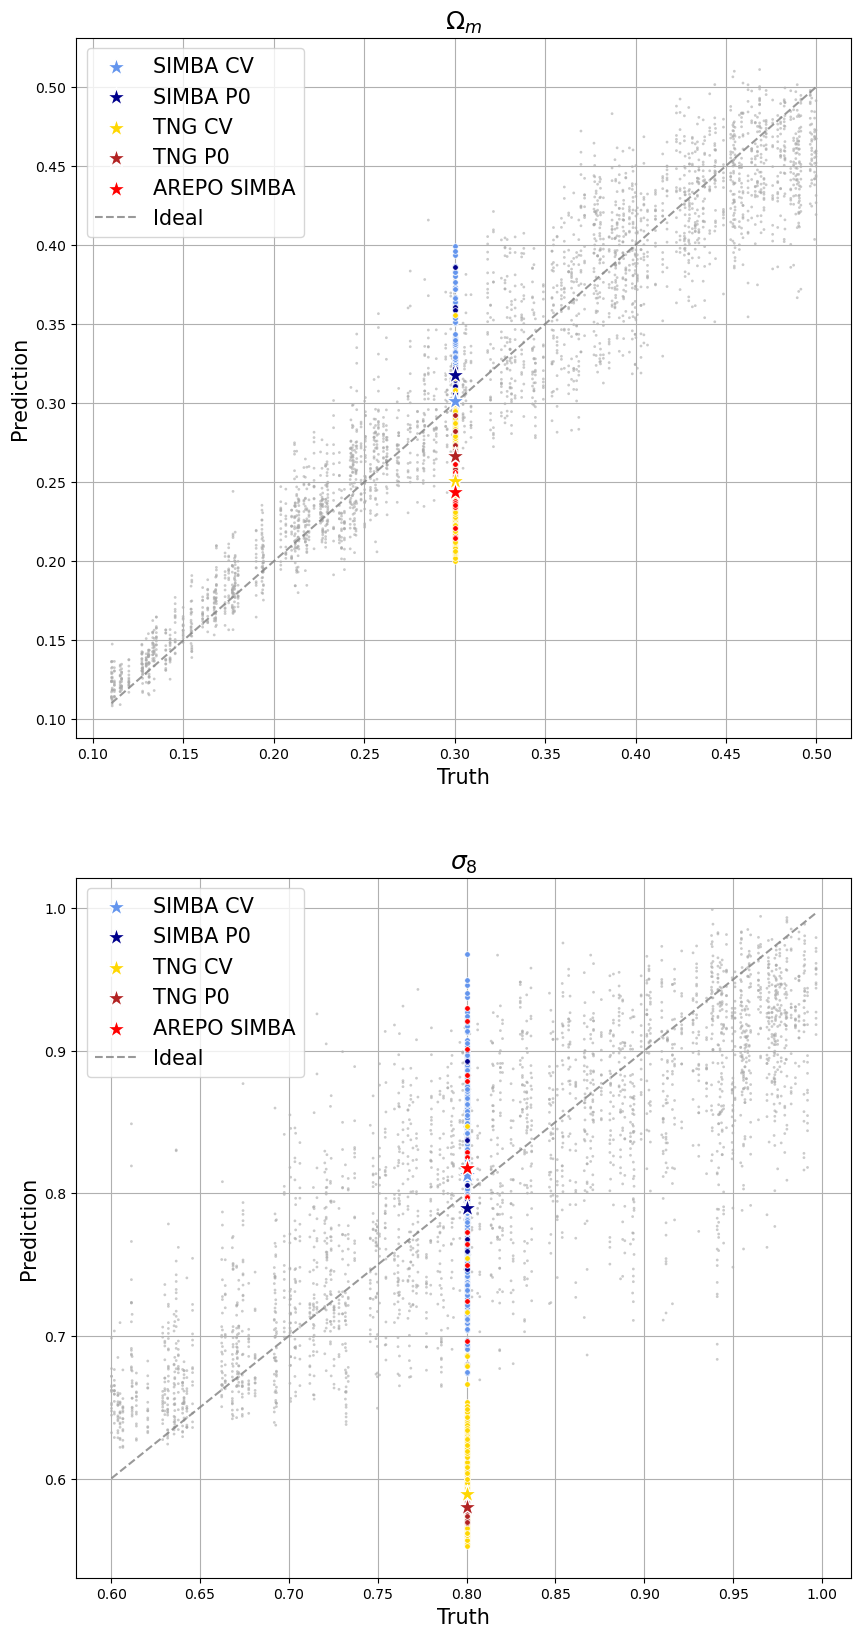

In [8]:
plot_AREPO_SIMBA(data0, pred, figsize=(10,20))
plt.savefig("../output_simba.png")

0.02762057841741819
0.02841563982381623
0.02086666100182839
0.01639526136764771
0.01723640677736281
0.05633193776590102
0.07142658136092328
0.029222202804455002
0.007103851479203659
0.0696943325317761


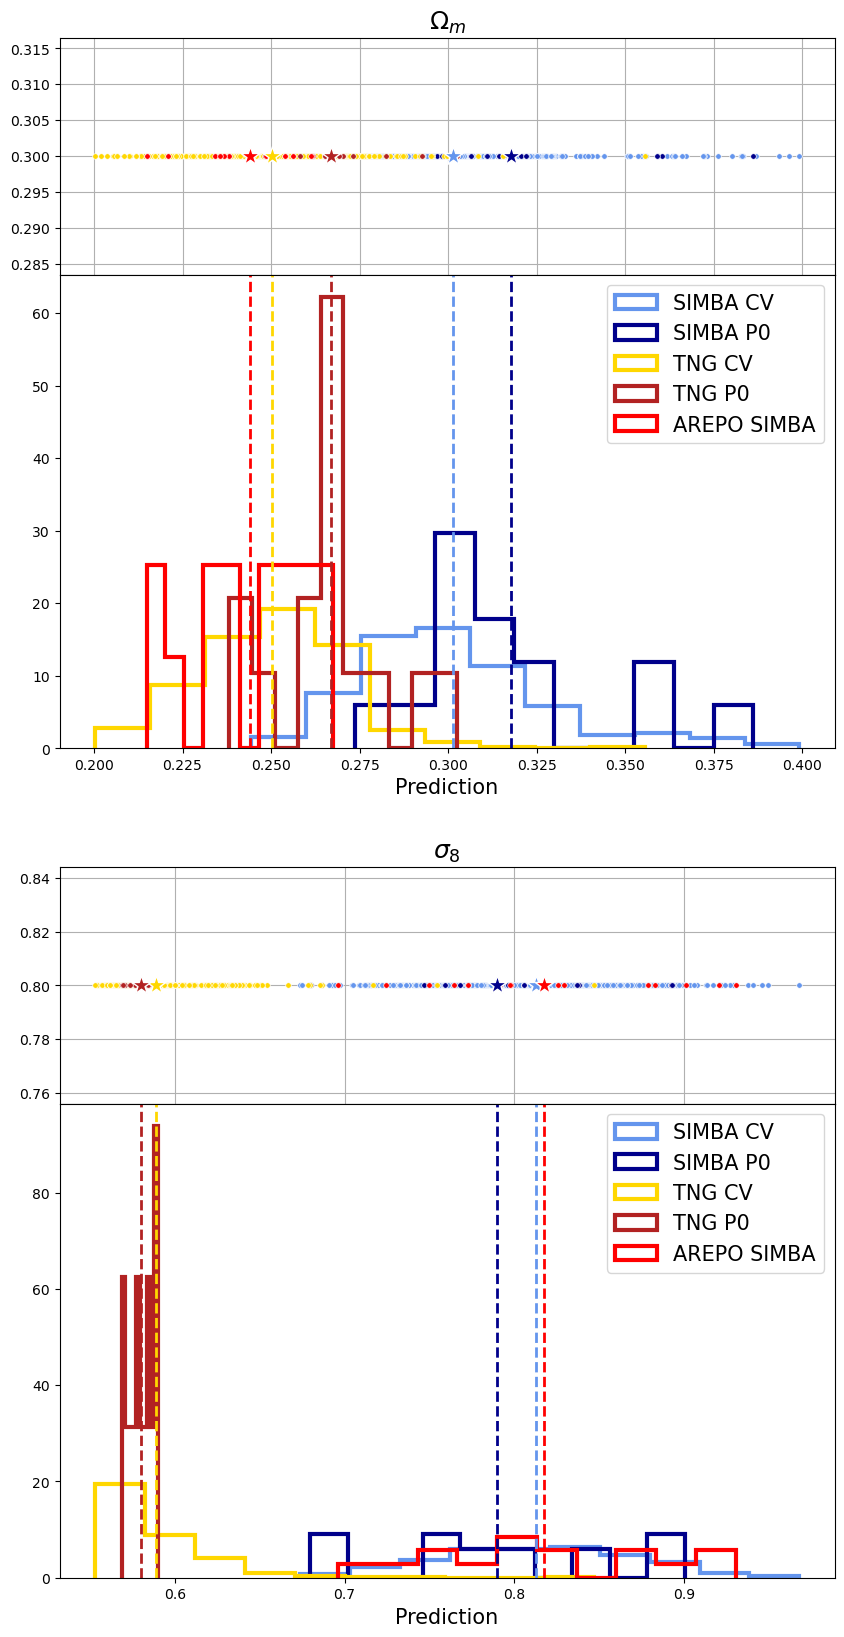

In [9]:
fiducial_histogram(pred, figsize=(10,20))
plt.savefig("../histogram_simba.png")

## On TNG

### data load

In [10]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()

30828

In [11]:
batch_size=64
_dataSIMBA, _labelsSIMBA, _minmaxSIMBA          = loadCAMELS(sim="IllustrisTNG",field="T",box="LH", normalization=False)
_dataSIMBA_CV, _labelsSIMBA_CV, _minmaxSIMBA_CV = loadCAMELS(sim="SIMBA",field="T",box="CV", normalization=False)
_dataSIMBA_P0, _labelsSIMBA_P0, _minmaxSIMBA_P0 = loadCAMELS(sim="SIMBA",field="T",box="1P", normalization=False)
_dataTNG_CV, _labelsTNG_CV, _minmaxTNG_CV       = loadCAMELS(sim="IllustrisTNG",field="T",box="CV", normalization=False)
_dataTNG_P0, _labelsTNG_P0, _minmaxTNG_P0       = loadCAMELS(sim="IllustrisTNG",field="T",box="1P", normalization=False)
#_dataAREPO_SIMBA = np.load("/mnt/ceph/users/fgarcia/data_products/simba_test_latest/Images_T_simba_test_bh_fgas_1_032_z=0.05.npy")
_dataAREPO_SIMBA = np.load("/mnt/ceph/users/fgarcia/data_products/simba_test_latest_z0/Images_T_arepo_simba_latest_033_z=0.00.npy")
#_dataAREPO_SIMBA = np.load("/mnt/ceph/users/fgarcia/data_products/simba_test_latest_temp_maps_z0/gas_temperature_033.npy")
_labelsAREPO_SIMBA = _labelsSIMBA_CV[0,:].reshape(1,-1)

_dataList   = [_dataSIMBA_CV, _dataSIMBA_P0[30:45,:,:], _dataTNG_CV, _dataTNG_P0[30:45,:,:], _dataAREPO_SIMBA]
#_labelsList = [_labelsSIMBA_CV, _labelsSIMBA_P0[2,:], _labelsTNG_CV, _labelsSIMBA_P0[2,:], _labelsAREPO_SIMBA]

In [12]:
dataSIMBA_norm = np.log10(_dataSIMBA)
dataSIMBA_norm_mean, dataSIMBA_norm_std = dataSIMBA_norm.mean(), dataSIMBA_norm.std()
dataSIMBA_norm = (dataSIMBA_norm -  dataSIMBA_norm_mean)/dataSIMBA_norm_std

dataList_norm = list()

for i in range(len(_dataList)):
  data_tmp = (np.log10(_dataList[i]) - dataSIMBA_norm_mean)/dataSIMBA_norm_std
  dataList_norm.append(data_tmp)

labelsSIMBA = _labelsSIMBA[:,:2]
labelsSIMBA = (labelsSIMBA-_minmaxSIMBA[:2,0])/(_minmaxSIMBA[:2,1]-_minmaxSIMBA[:2,0])

In [13]:
dataSIMBA = torch.tensor(dataSIMBA_norm,dtype=dtype)
labelsSIMBA = torch.tensor(labelsSIMBA,dtype=dtype)
train_setSIMBA, val_setSIMBA = split_expanded_dataset(dataSIMBA, labelsSIMBA, chunk_size=15, val_ratio=0.2)
val_loaderSIMBA = DataLoader(val_setSIMBA, batch_size=batch_size, shuffle=False)

In [14]:
import validator 
importlib.reload(validator)
from validator import *
output_dim = 1

model1 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model1.to(device)
model2 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model2.to(device)
model1.load_state_dict(torch.load("../data/models/IllustrisTNG_T_LH_om_no_linear_best.pt"))
model2.load_state_dict(torch.load("../data/models/IllustrisTNG_T_LH_sig_no_linear_best.pt"))

data0 = get_predictions0(model1, model2, val_loaderSIMBA, _minmaxSIMBA, device=device, max_plots=6)
pred  = get_predictions1(model1, model2, dataList_norm, _minmaxSIMBA, device=device, max_plots=6)
#plt.savefig("train_on_SB28_test_on_both.png")

Validation MSE (average over 2 targets): 6.444239e-04


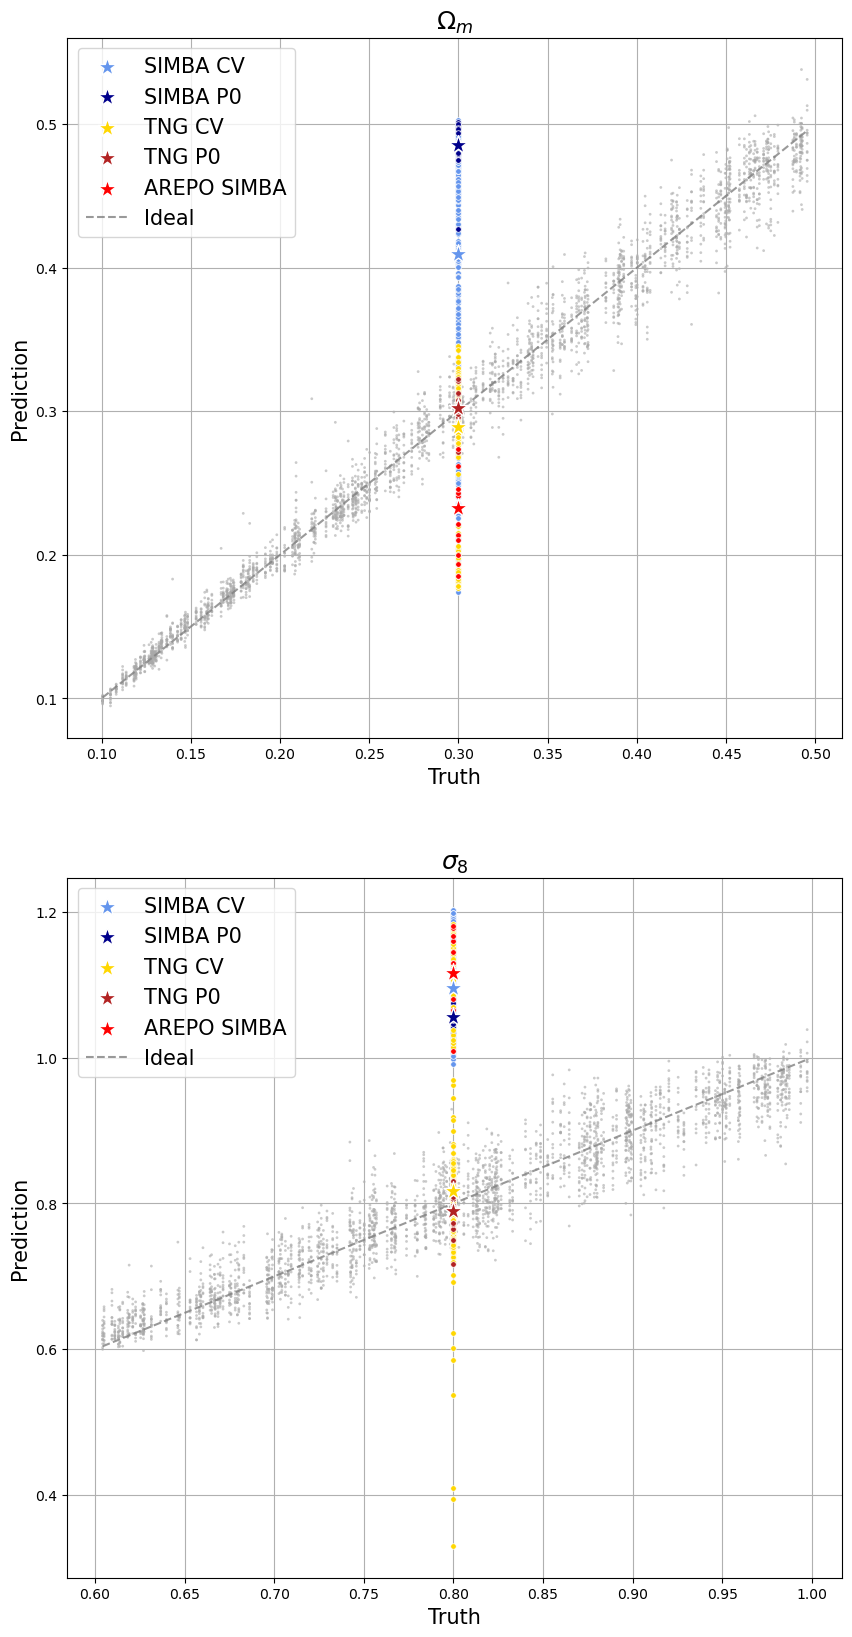

In [15]:
plot_AREPO_SIMBA(data0, pred, figsize=(10,20))
plt.savefig("../output_tng.png")

0.09087387277672027
0.018306377971698574
0.03668202462546791
0.01215219700232669
0.03004811713501925
0.06188284237974417
0.01871893821237685
0.10319223750156435
0.02855540444275343
0.04705904517002916


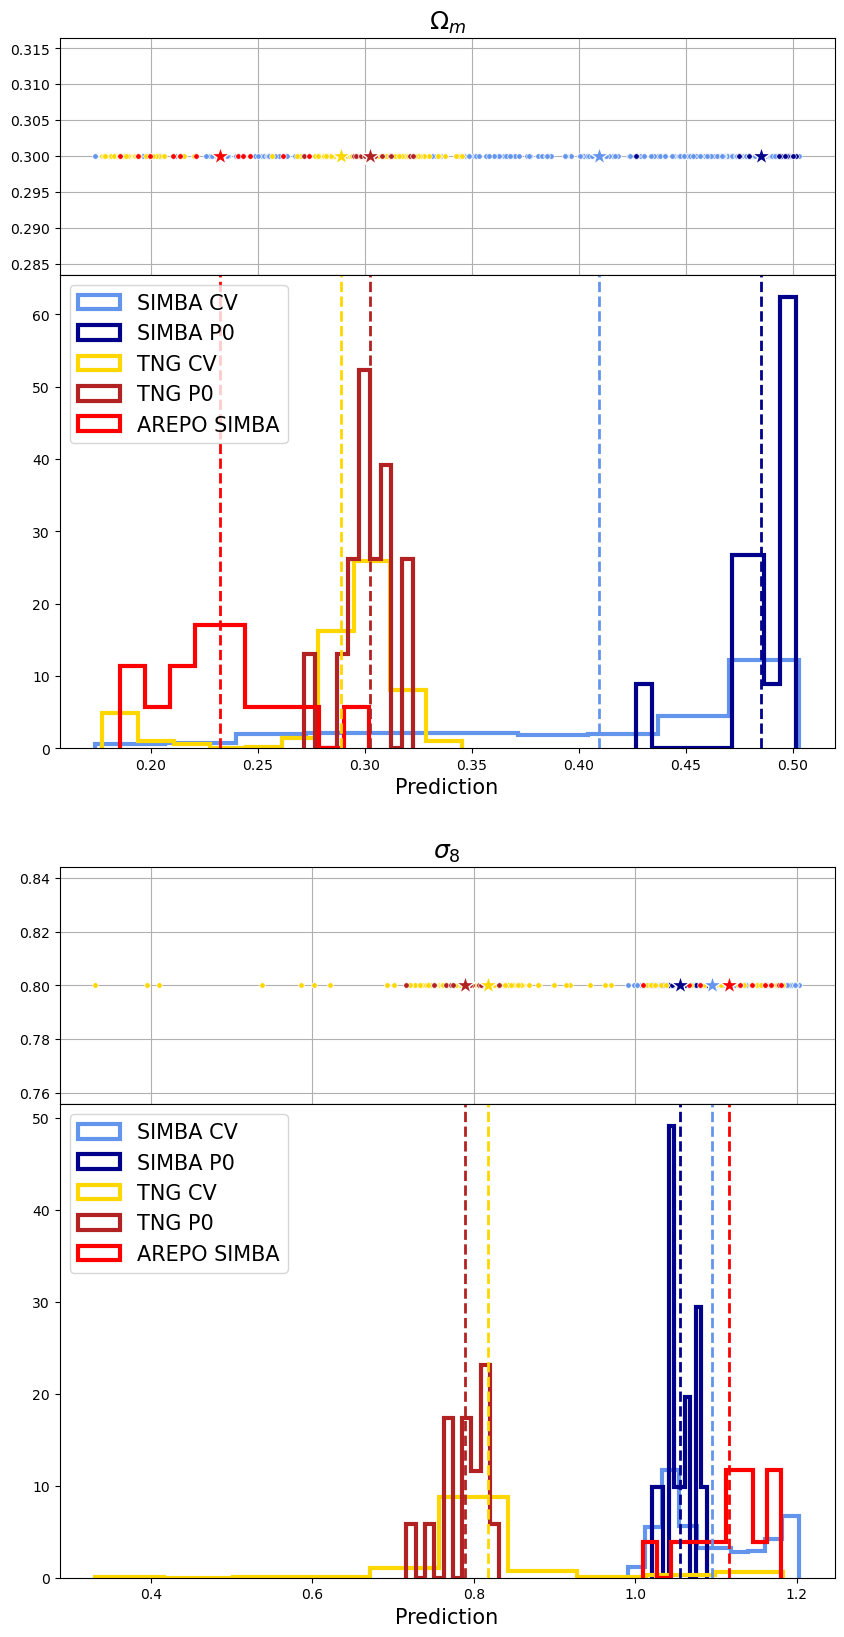

In [16]:
fiducial_histogram(pred, figsize=(10,20))
plt.savefig("../histogram_tng.png")

## On TNG+SIMBA

### data load

In [17]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()

30373

In [18]:
batch_size=64
_dataSIMBA, _labelsSIMBA, _minmaxSIMBA          = loadCAMELS(sim="SIMBA",field="T",box="LH", normalization=False)
_dataTNG, _labelsTNG, _minmaxTNG                = loadCAMELS(sim="IllustrisTNG",field="T",box="LH", normalization=False)
_dataSIMBA_CV, _labelsSIMBA_CV, _minmaxSIMBA_CV = loadCAMELS(sim="SIMBA",field="T",box="CV", normalization=False)
_dataSIMBA_P0, _labelsSIMBA_P0, _minmaxSIMBA_P0 = loadCAMELS(sim="SIMBA",field="T",box="1P", normalization=False)
_dataTNG_CV, _labelsTNG_CV, _minmaxTNG_CV       = loadCAMELS(sim="IllustrisTNG",field="T",box="CV", normalization=False)
_dataTNG_P0, _labelsTNG_P0, _minmaxTNG_P0       = loadCAMELS(sim="IllustrisTNG",field="T",box="1P", normalization=False)
#_dataAREPO_SIMBA = np.load("/mnt/ceph/users/fgarcia/data_products/simba_test_latest/Images_T_simba_test_bh_fgas_1_032_z=0.05.npy")
_dataAREPO_SIMBA = np.load("/mnt/ceph/users/fgarcia/data_products/simba_test_latest_z0/Images_T_arepo_simba_latest_033_z=0.00.npy")
_labelsAREPO_SIMBA = _labelsSIMBA_CV[0,:].reshape(1,-1)

_dataList   = [_dataSIMBA_CV, _dataSIMBA_P0[30:45,:,:], _dataTNG_CV, _dataTNG_P0[30:45,:,:], _dataAREPO_SIMBA]
#_labelsList = [_labelsSIMBA_CV, _labelsSIMBA_P0[2,:], _labelsTNG_CV, _labelsSIMBA_P0[2,:], _labelsAREPO_SIMBA]

In [19]:
dataALL = np.concatenate([_dataTNG, _dataSIMBA], axis=0)
dataALL_norm = np.log10(dataALL)

dataALL_norm_mean, dataALL_norm_std = dataALL_norm.mean(), dataALL_norm.std()
dataALL_norm = (dataALL_norm -  dataALL_norm_mean)/dataALL_norm_std

dataList_norm = list()
for i in range(len(_dataList)):
  data_tmp = (np.log10(_dataList[i]) - dataALL_norm_mean)/dataALL_norm_std
  dataList_norm.append(data_tmp)

labelsTNG = _labelsTNG[:,:2]
labelsSIMBA = _labelsSIMBA[:,:2]
labelsALL = np.concatenate([labelsTNG, labelsSIMBA], axis=0)

buffer = 0.3
_min = labelsALL.min(axis=0)
_max = labelsALL.max(axis=0)
_min -= (_max-_min)*(1-buffer)
_max += (_max-_min)*buffer
labelsALL = (labelsALL-_min)/(_max-_min)
_minmaxALL =  np.c_[_min,_max]

In [20]:
dataALL = torch.tensor(dataALL_norm,dtype=dtype)
labelsALL = torch.tensor(labelsALL,dtype=dtype)
train_setALL, val_setALL = split_expanded_dataset(dataALL, labelsALL, chunk_size=15, val_ratio=0.2)
val_loaderALL = DataLoader(val_setALL, batch_size=batch_size, shuffle=False)

In [21]:
import validator 
importlib.reload(validator)
from validator import *
output_dim = 1

model1 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model1.to(device)
model2 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model2.to(device)
model1.load_state_dict(torch.load("../data/models/TNG_SIMBA_T_LH_om_no_linear_best.pt"))
model2.load_state_dict(torch.load("../data/models/TNG_SIMBA_T_LH_sig_no_linear_best.pt"))

data0 = get_predictions0(model1, model2, val_loaderALL, _minmaxALL, device=device, max_plots=6)
pred  = get_predictions1(model1, model2, dataList_norm, _minmaxALL, device=device, max_plots=6)
#plt.savefig("train_on_SB28_test_on_both.png")

Validation MSE (average over 2 targets): 1.311447e-03


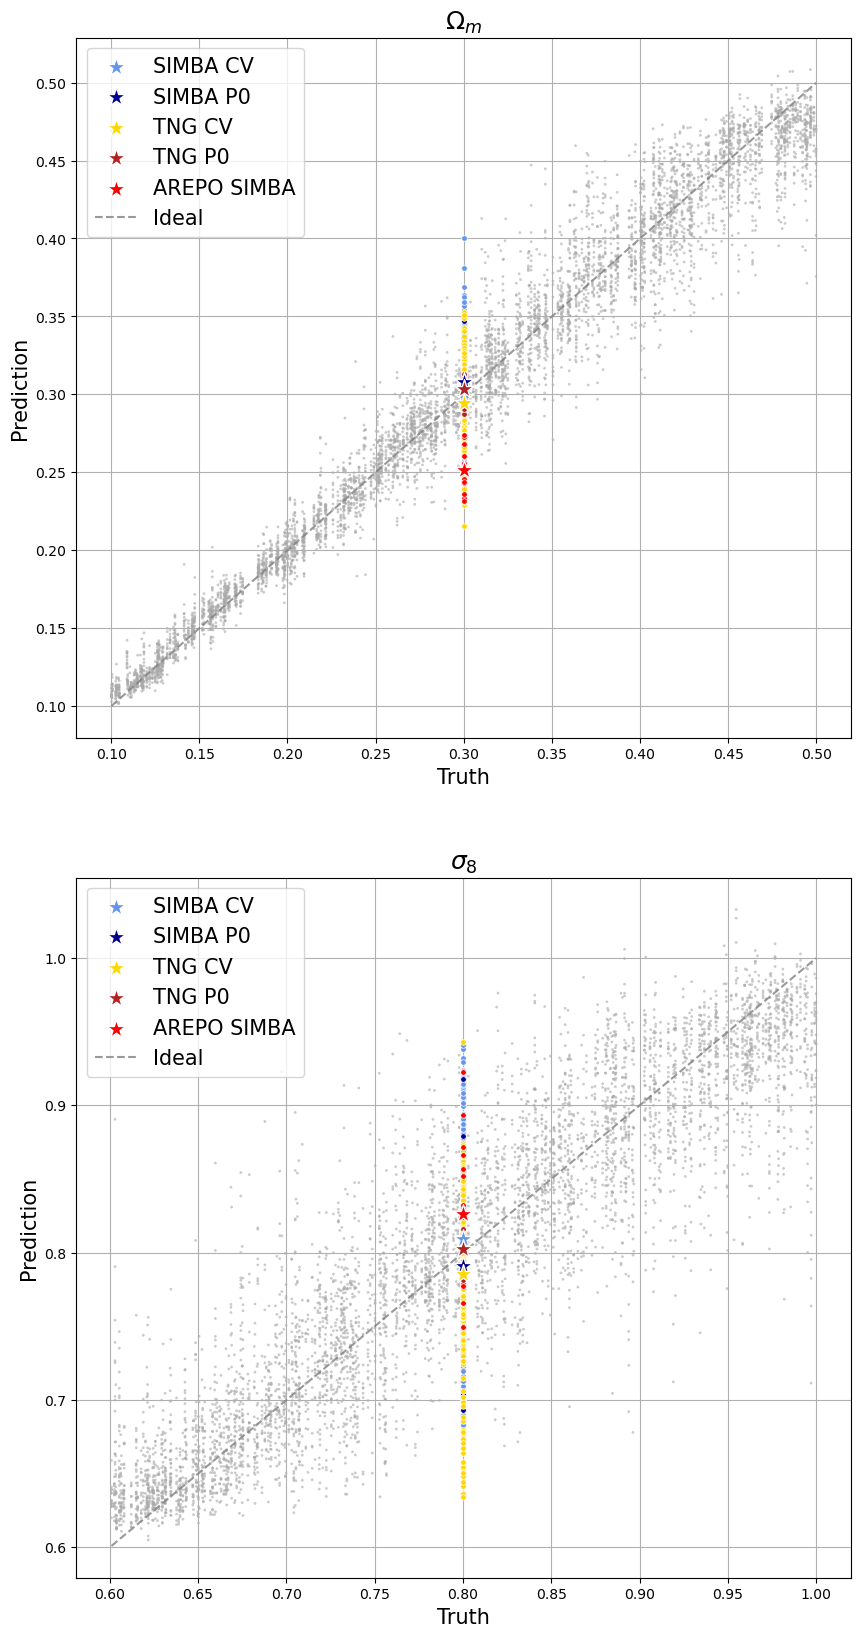

In [22]:
plot_AREPO_SIMBA(data0, pred, figsize=(10,20))
plt.savefig("../output_tng+simba.png")

0.02560175370302656
0.02226101035895827
0.021550367062141314
0.008875927355063944
0.012965510618497073
0.058888480725349704
0.0799594903387058
0.04726258287001612
0.016627986265261848
0.04828239314035453


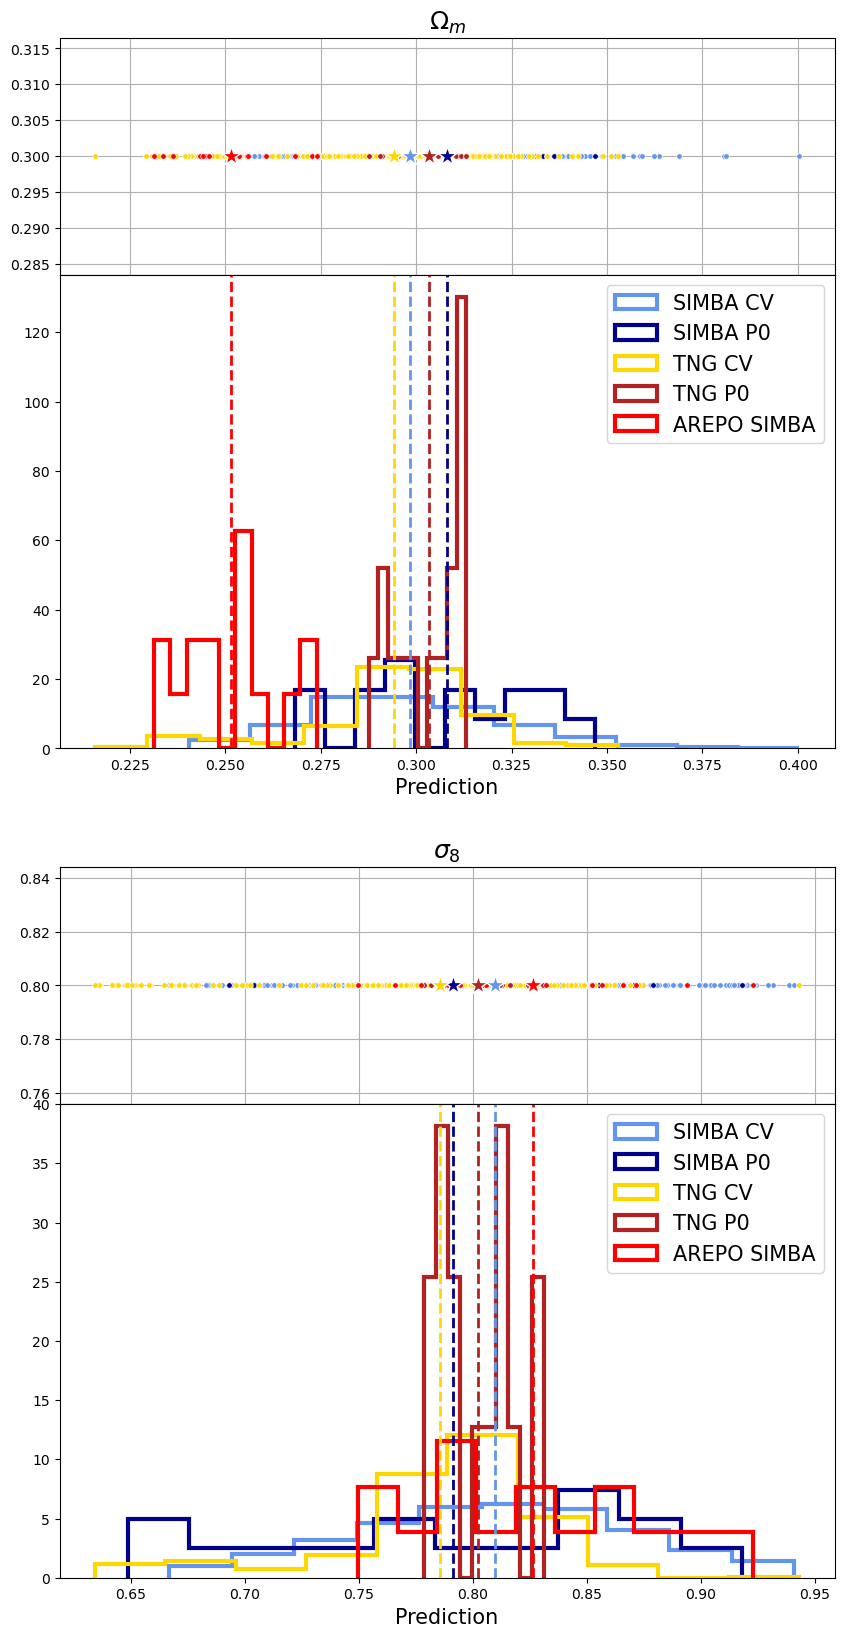

In [23]:
fiducial_histogram(pred, figsize=(10,20))
plt.savefig("../histogram_tng+simba.png")

## On MIEST

In [24]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()

30567

In [25]:
batch_size=64
_dataSIMBA, _labelsSIMBA, _minmaxSIMBA          = loadCAMELS(sim="SIMBA",field="T",box="LH", normalization=False)
_dataTNG, _labelsTNG, _minmaxTNG                = loadCAMELS(sim="IllustrisTNG",field="T",box="LH", normalization=False)
_dataSIMBA_CV, _labelsSIMBA_CV, _minmaxSIMBA_CV = loadCAMELS(sim="SIMBA",field="T",box="CV", normalization=False)
_dataSIMBA_P0, _labelsSIMBA_P0, _minmaxSIMBA_P0 = loadCAMELS(sim="SIMBA",field="T",box="1P", normalization=False)
_dataTNG_CV, _labelsTNG_CV, _minmaxTNG_CV       = loadCAMELS(sim="IllustrisTNG",field="T",box="CV", normalization=False)
_dataTNG_P0, _labelsTNG_P0, _minmaxTNG_P0       = loadCAMELS(sim="IllustrisTNG",field="T",box="1P", normalization=False)
#_dataAREPO_SIMBA = np.load("/mnt/ceph/users/fgarcia/data_products/simba_test_latest/Images_T_simba_test_bh_fgas_1_032_z=0.05.npy")
_dataAREPO_SIMBA = np.load("/mnt/ceph/users/fgarcia/data_products/simba_test_latest_z0/Images_T_arepo_simba_latest_033_z=0.00.npy")
#_dataAREPO_SIMBA = np.load("/mnt/ceph/users/fgarcia/data_products/simba_test_latest_temp_maps_z0/gas_temperature_033.npy")
_labelsAREPO_SIMBA = _labelsSIMBA_CV[0,:].reshape(1,-1)

_dataList   = [_dataSIMBA_CV, _dataSIMBA_P0[30:45,:,:], _dataTNG_CV, _dataTNG_P0[30:45,:,:], _dataAREPO_SIMBA]
#_labelsList = [_labelsSIMBA_CV, _labelsSIMBA_P0[2,:], _labelsTNG_CV, _labelsSIMBA_P0[2,:], _labelsAREPO_SIMBA]

In [26]:
dataMIEST_norm = np.r_[np.log10(_dataSIMBA), np.log10(_dataTNG)]

dataMIEST_norm_mean, dataMIEST_norm_std = dataMIEST_norm.mean(), dataMIEST_norm.std()
dataMIEST_norm = (dataMIEST_norm -  dataMIEST_norm_mean)/dataMIEST_norm_std

dataList_norm = list()

for i in range(len(_dataList)):
  data_tmp = (np.log10(_dataList[i]) - dataMIEST_norm_mean)/dataMIEST_norm_std
  dataList_norm.append(data_tmp)

In [27]:
import validator 
importlib.reload(validator)
from validator import *
sys.path.append("/mnt/home/yjo10/ceph/CAMELS/MIEST/utils")
import mist_utils as mu
output_dim = 1
batch_size = 64
mist = mu.MIST(sim=["TNG", "SIMBA"], field="T", batch_size=batch_size,
              data_type = 'image',
              normalization=True,
              monopole=True,
              device=device, robust_axis="sim")

#data0 = get_predictions0(model1, model2, val_loaderSIMBA, _minmaxSIMBA, device=device, max_plots=6)
#pred  = get_predictions1(model1, model2, dataList_norm, _minmaxSIMBA, device=device, max_plots=6)
#plt.savefig("train_on_SB28_test_on_both.png")

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


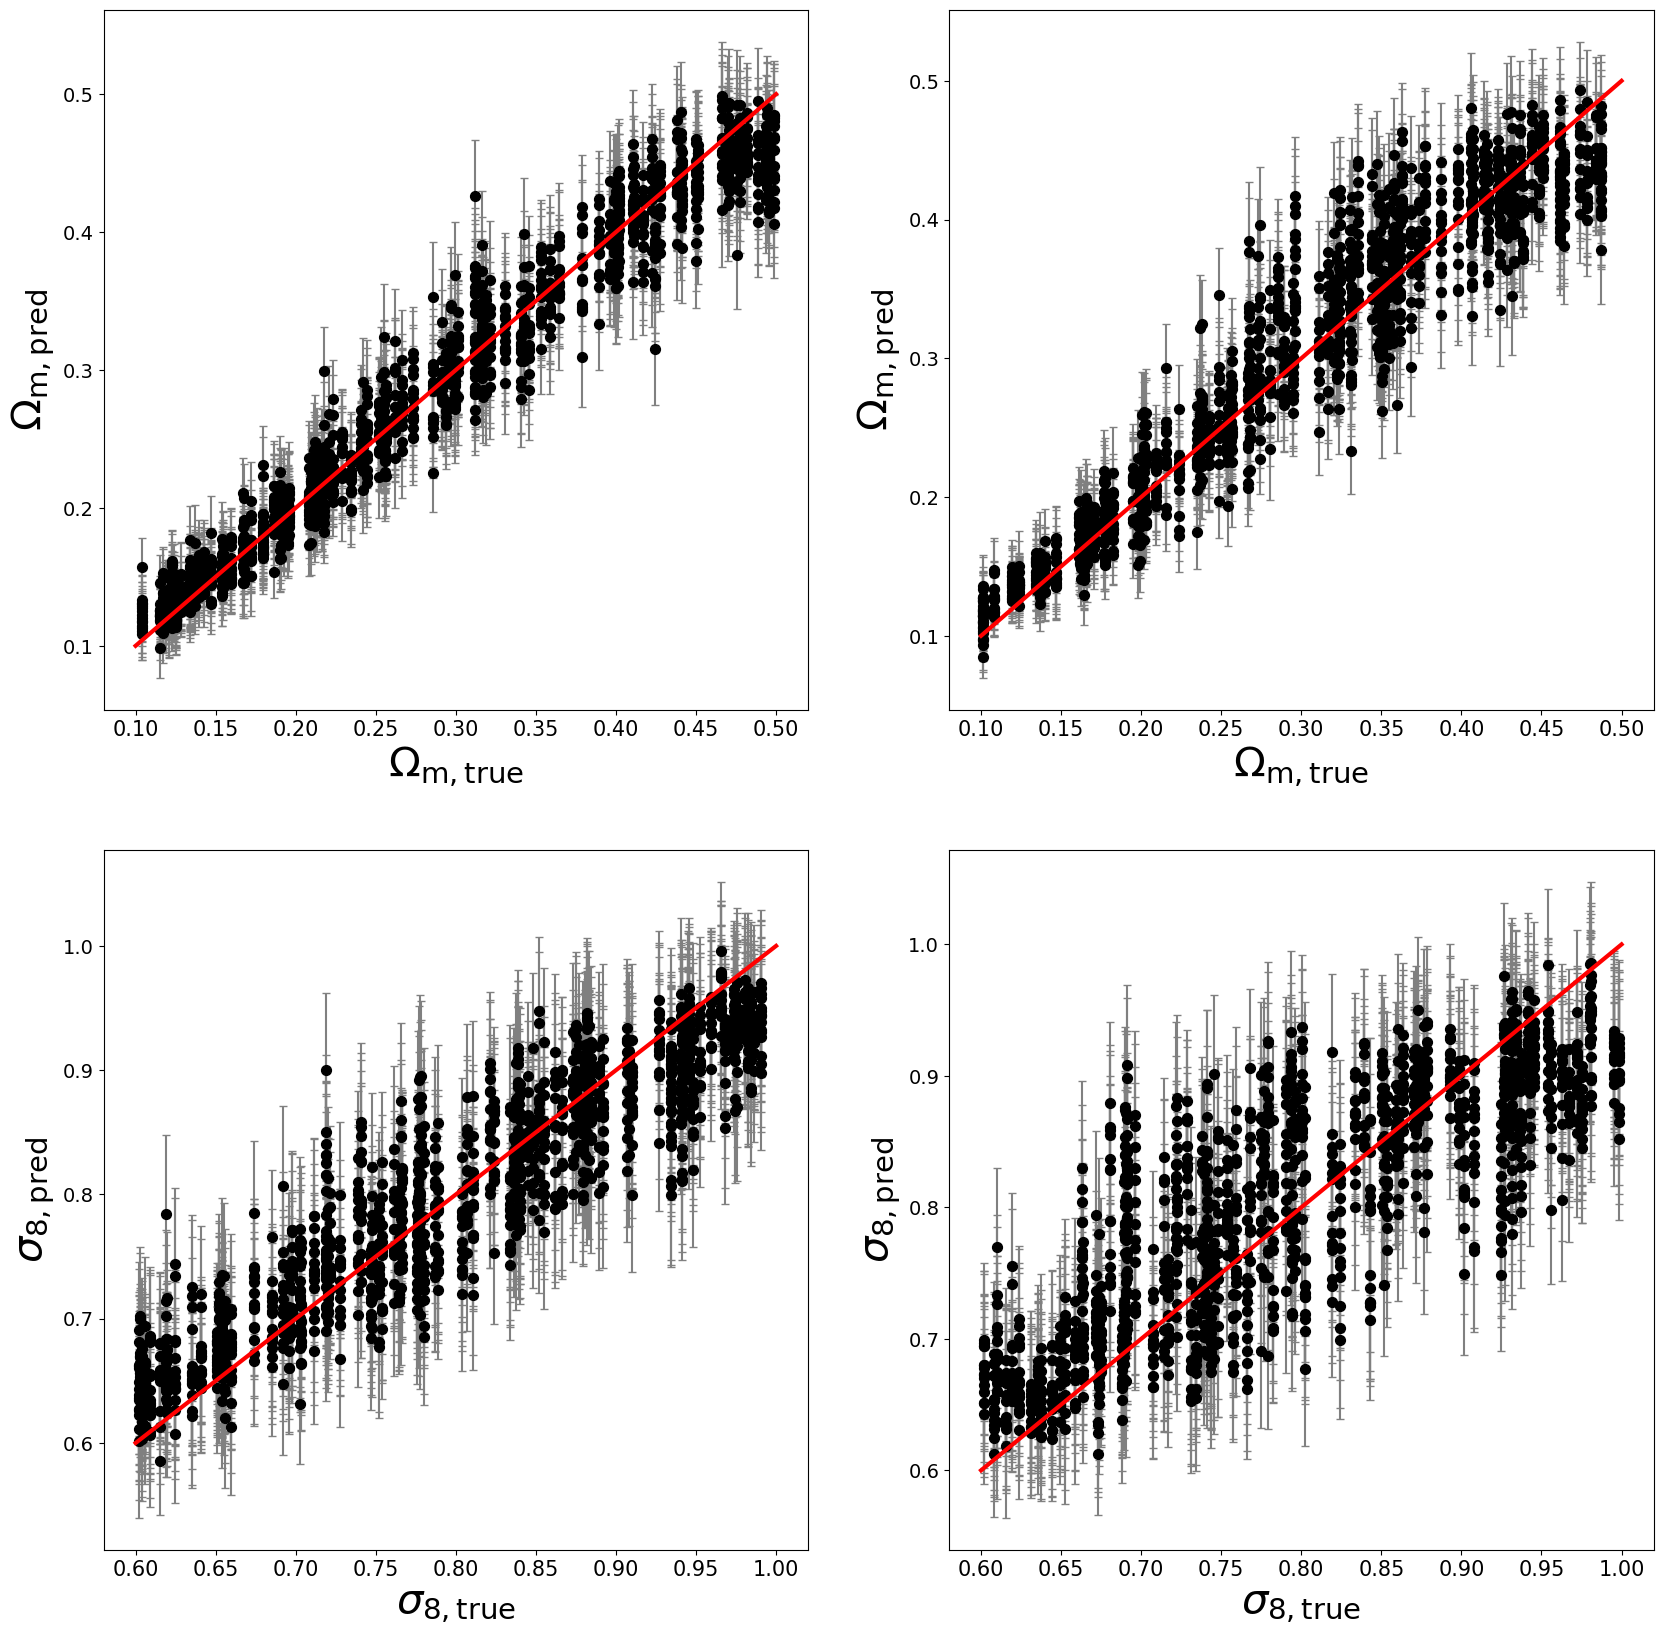

In [28]:
study_name = "TNG_SIMBA_T_cnn_mid_monopole_1_new_split"
fpath = '/mnt/home/yjo10/ceph/CAMELS/MIEST/information_bottleneck'
storage    = f"sqlite:////mnt/home/yjo10/ceph/CAMELS/MIEST/information_bottleneck/database/{study_name}.db"
mist.load_optuna_models(storage=storage,study_name=study_name, which_machine="cnn_enc_dec",num_trial=None, fpath=fpath)
y_true, y_pred, y_std = mist.make_plots_cnn(fname='cnn_test', save_plot=False, data_return=True)

In [29]:
pred = list()
for X in dataList_norm:
  X = torch.tensor(dataList_norm[0]).to(device)
  X = X.reshape(-1,1,256,256)
  _pred, std = mist.predict_cnn(X)
  pred.append(_pred)

In [30]:
y_true[0].shape

(1515, 2)

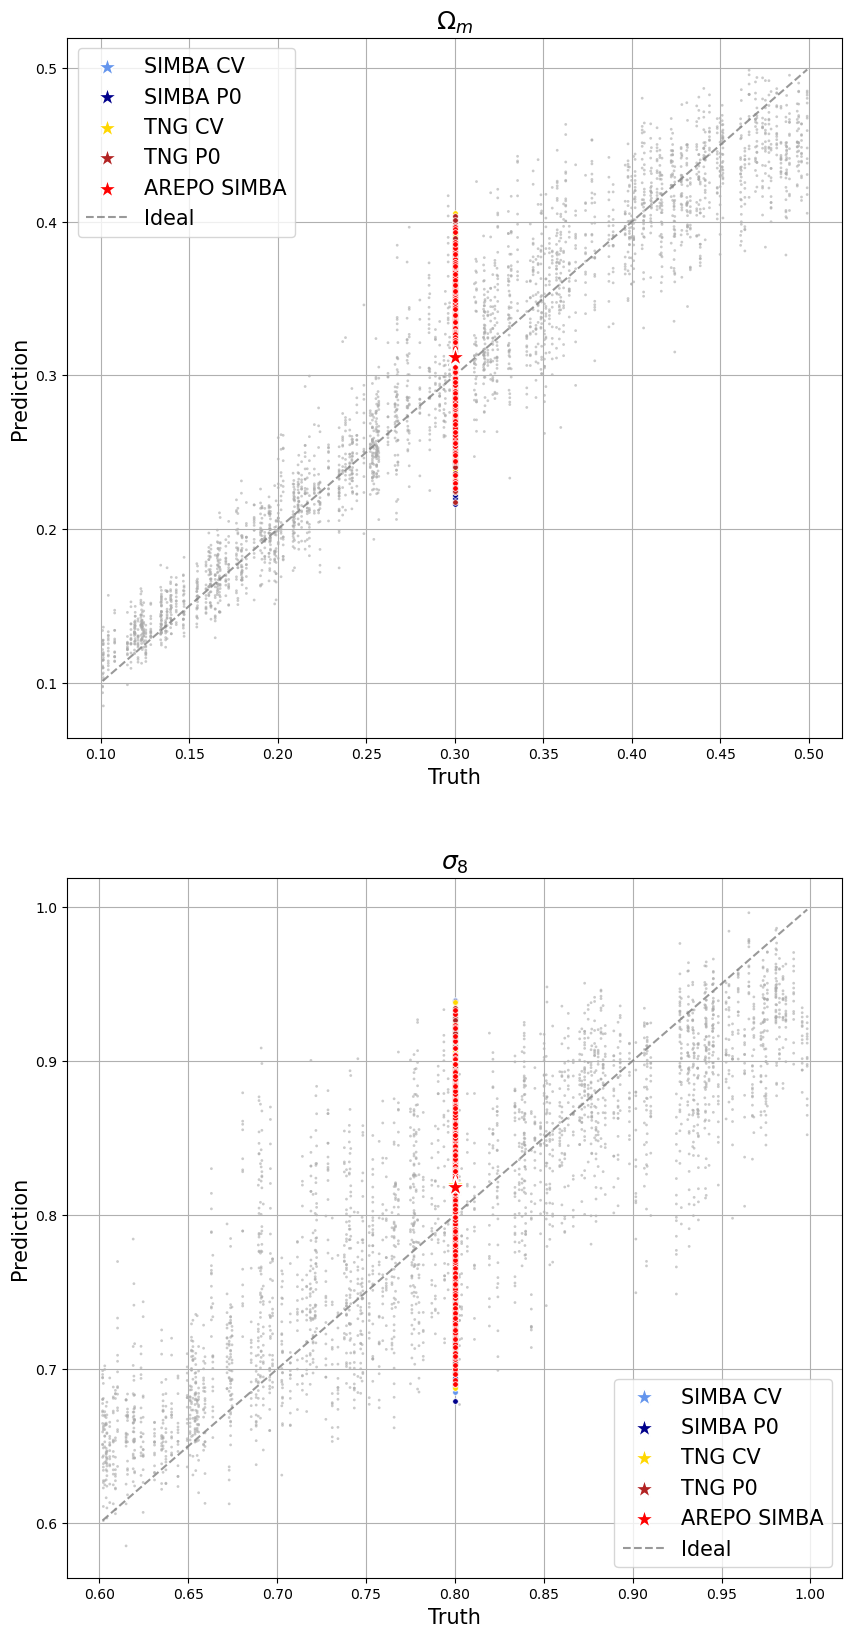

In [31]:
plot_AREPO_SIMBA([np.r_[y_true[0], y_true[1]],np.r_[y_pred[0],y_pred[1]], 2], pred, figsize=(10,20))
plt.savefig("../output_miest.png")

0.03356454813366008
0.0333889956798946
0.03355643497879569
0.033087880342081585
0.033365630398045236
0.051066468944610456
0.05064254615182782
0.0510576367751668
0.05080839687086511
0.051587600523591175


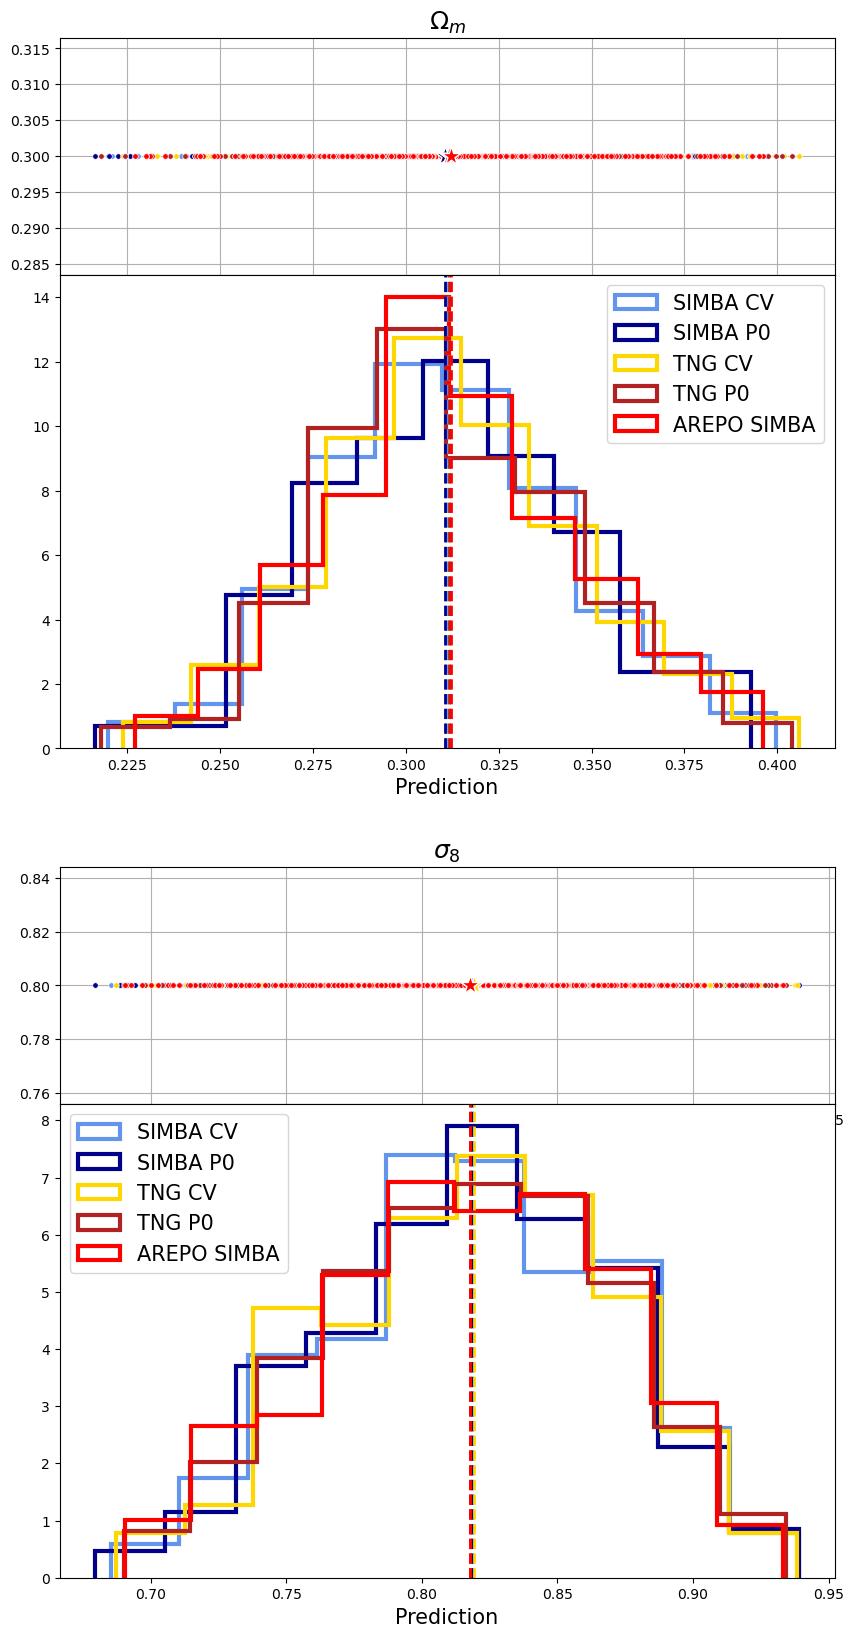

In [32]:
fiducial_histogram(pred, figsize=(10,20))
plt.savefig("../histogram_miest.png")